# Environment Setup

In [1]:
# Install HappyML
import os

if not os.path.isdir("HappyML"):
  os.system("git clone https://github.com/cnchi/HappyML.git")

In [2]:
# Dataset Download

if not os.path.isfile("cats_and_dogs_filtered.zip"):
  !wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

  # Unzip the file
  import zipfile

  zip_file = zipfile.ZipFile('cats_and_dogs_filtered.zip', 'r')
  zip_file.extractall()
  zip_file.close()

--2023-11-14 06:44:39--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.192.207, 209.85.146.207, 209.85.147.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.192.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   264MB/s    in 0.2s    

2023-11-14 06:44:39 (264 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [15]:
# Dataset Path Setting
# Use the same Dataset from the previous practice, so we can compare them
base_dir = 'cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'validation')

# Model Related Setting
to_train = True
image_size = 224
model_file = "CatsDogs_VGG16_224x224.h5" # save model file name

# Image Preprocessing

In [5]:
# Generate Training / Validation Set
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.75, # simulate the sparescity of training data
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True)

train_set = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(image_size, image_size),
    batch_size=10,
    class_mode="binary",
    subset="training")

val_set = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(image_size, image_size),
    batch_size=10,
    class_mode="binary",
    subset="validation")

Found 500 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.


In [6]:
# Generate Testing Set
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_set = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(image_size, image_size),
    batch_size=10,
    class_mode="binary")

Found 1000 images belonging to 2 classes.


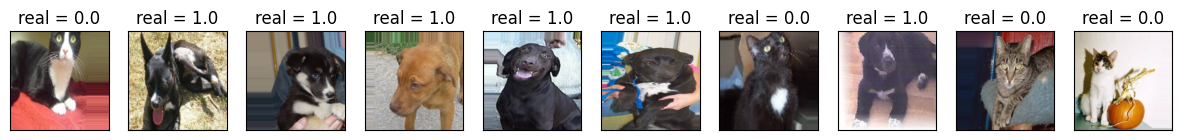

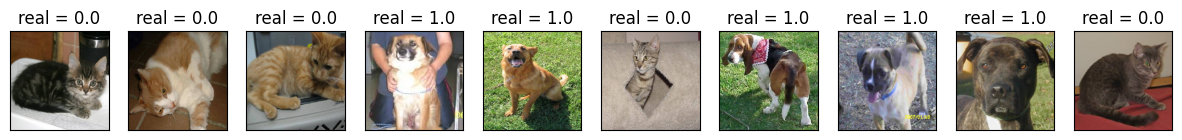

In [7]:
# Validate the Success of Image Loading
import HappyML.model_drawer as md

# Print the first 10 images of Training Set
for data, label in train_set:
    md.show_first_n_images(x_ary=data, y_real=label, first_n=10, font_size=12)
    break

# Print the first 10 images of Testing Set
for data, label in test_set:
    md.show_first_n_images(x_ary=data, y_real=label, first_n=10, font_size=12)
    break

# Build Model

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16

# Create CNN Model Backbone
model = Sequential()

In [10]:
# Load VGG16 as Convolutional Layers
vgg16 = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size, image_size, 3))

vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
# Set the last 3 layers of VGG16 as trainable
is_trainable = ["block{}_conv{}".format(5, i) for i in range(1, 4)]

for layer in vgg16.layers:
    layer.trainable = True if layer.name in is_trainable else False

# vgg16.summary()

In [14]:
# Add each layers & Compile
# Do not run this cell separately
# It will add additional layers and cause error
model.add(vgg16)
model.add(layers.Flatten())
model.add(layers.Dense(units=512, activation="relu"))
model.add(layers.Dense(units=1, activation="sigmoid"))

from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(learning_rate=1e-5), loss="binary_crossentropy", metrics=["accuracy"])

# model.summary()

# Training

In [16]:
# Train & Save Model or Load Model
from tensorflow.keras.models import load_model

if to_train:
    model.fit(train_set, validation_data=val_set, epochs=10)
    model.save(model_file)
else:
    model = load_model(model_file)

Epoch 1/10
50/50 [==============================] - 49s 734ms/step - loss: 0.6111 - accuracy: 0.6660 - val_loss: 0.5047 - val_accuracy: 0.7687
Epoch 2/10
50/50 [==============================] - 31s 629ms/step - loss: 0.4391 - accuracy: 0.8020 - val_loss: 0.4861 - val_accuracy: 0.7487
Epoch 3/10
50/50 [==============================] - 29s 595ms/step - loss: 0.3182 - accuracy: 0.8760 - val_loss: 0.3480 - val_accuracy: 0.8413
Epoch 4/10
50/50 [==============================] - 29s 595ms/step - loss: 0.2375 - accuracy: 0.9020 - val_loss: 0.3653 - val_accuracy: 0.8287
Epoch 5/10
50/50 [==============================] - 30s 607ms/step - loss: 0.2195 - accuracy: 0.9120 - val_loss: 0.2758 - val_accuracy: 0.8780
Epoch 6/10
50/50 [==============================] - 30s 599ms/step - loss: 0.1938 - accuracy: 0.9180 - val_loss: 0.2683 - val_accuracy: 0.8947
Epoch 7/10
50/50 [==============================] - 31s 639ms/step - loss: 0.1665 - accuracy: 0.9300 - val_loss: 0.2344 - val_accuracy: 0.9053

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Evaluation

In [17]:
# Model Evaluation
test_loss, test_acc = model.evaluate(test_set)
print("Loss of Test:", test_loss)
print("Accuracy of Test:", test_acc)

100/100 [==============================] - 5s 54ms/step - loss: 0.1565 - accuracy: 0.9360
Loss of Test: 0.15651610493659973
Accuracy of Test: 0.9359999895095825


# Inference

100/100 [==============================] - 5s 53ms/step


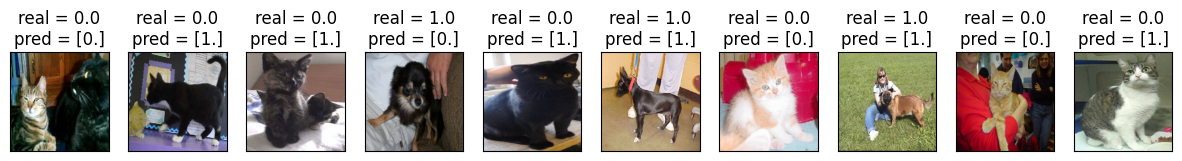

In [18]:
# Model Testing
import numpy as np

Y_pred = np.rint(model.predict(test_set))

for data, label in test_set:
    md.show_first_n_images(x_ary=data, y_real=label, y_pred=Y_pred[:10], first_n=10, font_size=12)
    break

1/1 [==============================] - 1s 1s/step
Cat


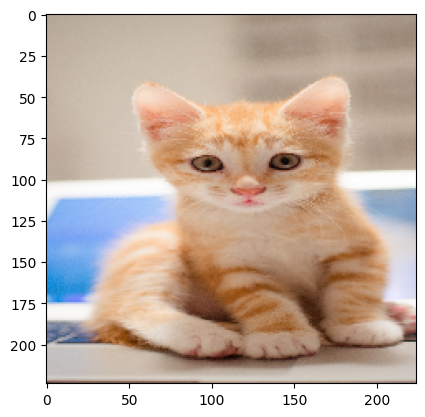

In [20]:
from tensorflow.keras.preprocessing import image

# download: https://th.bing.com/th/id/R.9145b4e20bfb78a9c1296efaf697ea2c?rik=hTlBSZic7oldxw&pid=ImgRaw&r=0

user_image = image.load_img("/content/cat.jpg", target_size=(image_size, image_size))
image_data = image.img_to_array(user_image) / 255
image_data = np.expand_dims(image_data, axis=0)

isDog = (model.predict(image_data) >= 0.5)
print("Dog" if isDog[0][0] else "Cat")

import matplotlib.pyplot as plt
plt.imshow(user_image)
plt.show()